In [1]:
# 필요한 라이브러리 import
from importlib.metadata import version
import nltk
nltk.download('stopwords')

import tensorflow as tf
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 버전 호환/충돌에 대비하여 각 라이브러리 버전 확인
print(nltk.__version__)
print(tf.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import urllib.request

# 뉴스 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 샘플 수: ',(len(data)))

전체 샘플 수:  98401


오늘 우리가 다뤄야할 데이터는 총 98401개이다.

In [3]:
# 데이터 확인
data.sample(10)

,headlines,text
9616,US teen shoots dead 61-yr-old Indian-origin ma...,A 61-year-old Indian-origin man has been shot ...
30864,RCom shares sink 20% after tribunal admits ins...,Shares of billionaire Anil Ambani-led Reliance...
18019,Serena fined Ã¢ÂÂ¹12 lakh for violations duri...,Twenty-three-time Grand Slam champion Serena W...
85160,Truth always wins: Uber whistleblower on compa...,"Uber's former employee Susan Fowler, who first..."
41511,"1,000 students may have accessed leaked CBSE p...",The Delhi Police Crime Branch on Friday claime...
51016,Spain develops AI that can predict corruption ...,Scientists in Spain have developed an artifici...
70435,IndiGo reports unruly flyer days after No-Fly ...,A female passenger on a Jaipur-Mumbai IndiGo f...
76278,Will ask Centre to ban Blue Whale Game in coun...,The Kerala CM on Wednesday said that the state...
11706,Pic of stranger holding sleeping baby as mom f...,A picture of a stranger holding a baby as the ...
62499,US Prez Trump blames Iran for missile fired at...,US President Donald Trump has accused Iran of ...


headlines와 text 컬럼만 존재하는 것을 확인할 수 있다. 추상적 요약을 하는 경우에는 text 컬럼을 본문, headlines 컬럼을 요약된 데이터로 사용할 수 있고, 추출적 요약의 경우에는 오직 text 컬럼만 사용한다.

In [4]:
print('text 컬럼의 중복되지 않은 데이터 개수: ', data['text'].nunique())
print('headlines 컬럼의 중복되지 않은 데이터 개수: ', data['headlines'].nunique())

text 컬럼의 중복되지 않은 데이터 개수:  98360
headlines 컬럼의 중복되지 않은 데이터 개수:  98280


text와 headlines컬럼의 중복되지 않은 데이터 개수는 각각 98,360개와 98,280개로 headlines의 경우 아주 간단한 요약들이 중복될 수 있지만, text의 경우 중복된 데이터는 말 그대로 중복 샘플이므로 제거해야 한다.

In [5]:
# text 컬럼에서 중복되는 샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플 수:', len(data))

전체 샘플 수: 98360


중복되는 text 샘플을 제거하여 전체 샘플 수가 98,401개에서 98,360개로 41개의 데이터가 배제되었다.  
drop_duplicates가 Null값을 제거해주긴 하지만, 깔끔한 처리를 위해 한 번 더 Null 값을 지워주도록 한다.

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null값이 존재하지 않으니, Null 제거 작업은 하지 않아도 될 것 같다.

In [7]:
# 텍스트 정규화를 위한 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


I will, I'll과 같은 뜻이 같은 표현들은 연산량 조절을 위해 미리 제작된 정규화 딕셔너리를 사용하여 표현을 통일시켜 정규화를 진행하기로 한다.  
또한 학습에 도움이 되지 않는 불용어를 확인하고 제거하는 작업을 진행한다.

In [8]:
# stopwords 영어 부분에 속해 있는 단어 개수 및 종류 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

stopwords에 들어있는 영문 불용어는 총 179개의 데이터가 있는 것을 알 수 있고, 우리는 데이터 전처리를 통해 데이터셋에 포함된 불용어를 제거할 것이다.

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    # 데이터를 소문자로 변환
    sentence = sentence.lower()
    # html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    # 괄호 포함 그 안에 갇힌 문자열 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    # 쌍따옴표 제거
    sentence = re.sub('"','', sentence)
    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    # 소유격 제거
    sentence = re.sub(r"'s\b","", sentence)
    # 영어 외의 문자를 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    # m이 세 개 이상 들어가면 mm으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # remove_stopwords를 flag로 text와 headlines를 구분
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

실제 데이터셋을 전처리 하기 전에 정의한 함수가 잘 동작하는지 확인해본다.

In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


전처리 함수에 설계한대로 임의의 데이터가 올바르게 변환되었으므로 실제 데이터셋의 전처리를 진행한다.

In [11]:
clean_text = []
clean_headlines = []

# text 데이터 전처리 진행 - 불용어 제거
for i in data['text']:
    clean_text.append(preprocess_sentence(i))
    
# headlines 데이터 전처리 진행 - 불용어 미제거
for i in data['headlines']:
    clean_headlines.append(preprocess_sentence(i, False))


# 각각의 데이터 일부 전처리 확인
print('text 전처리 결과: ', clean_text[:5])
print('headlines 전처리 결과: ', clean_headlines[:5])

text 전처리 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure 

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

정제 과정에서 문장의 모든 단어가 사라지는 경우가 있기 때문에 빈 값을 가진 샘플의 값을 Null로 대체하는 작업을 한다.

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


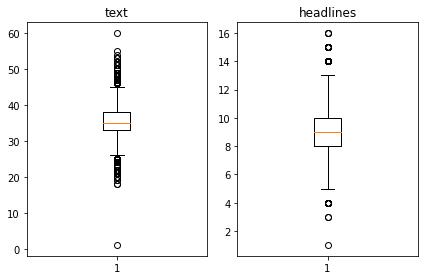

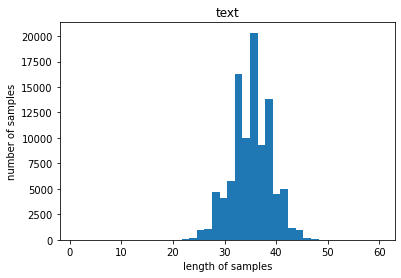

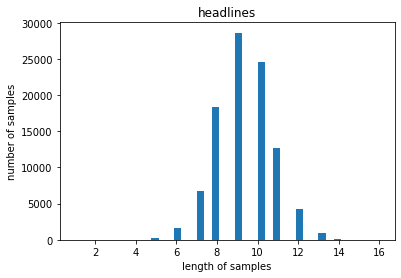

In [14]:
import matplotlib.pyplot as plt

# 각 로우 별 샘플 개수
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

# text와 headline 샘플의 분포 시각화
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text의 경우 샘플의 길이는 1부터 60까지로 평균 값은 약 35를 가지고, headlines의 경우 샘플의 길이는 1부터 16까지 평균은 약 9를 가진다.

In [15]:
# 패딩 값을 정하기 위해 지정 값 이하의 샘플 수의 비율을 찾는 함수 정의
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [16]:
# 일단 평균값인 35와 9로 지정
below_threshold_len(35, data['text'])
below_threshold_len(9,  data['headlines'])

전체 샘플 중 길이가 35 이하인 샘플의 비율: 0.5412464416429443
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.5666022773485156


In [17]:
# 최댓값인 60과 16으로 지정
below_threshold_len(60, data['text'])
below_threshold_len(16,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [18]:
# 그래프를 확인하여 임의의 값인 40과 12로 지정
below_threshold_len(40, data['text'])
below_threshold_len(12,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [19]:
# 그래프를 확인하여 임의의 값인 38과 11로 지정
below_threshold_len(38, data['text'])
below_threshold_len(11,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


적절한 최대 길이는 각각 38과 11로 지정하는 것이 적당할 것 같다.

In [20]:
text_max_len = 38
headlines_max_len = 11

In [21]:
# 길이가 38보다 긴 샘플을 공백으로 치환
data['text'] = data['text'].apply(lambda x: x if len(x.split()) <= text_max_len else '')
# 길이가 11보다 긴 샘플을 공백으로 치환
data['headlines'] = data['headlines'].apply(lambda x: x if len(x.split()) <= headlines_max_len else '')

# 공백인 샘플을 NaN으로 치환
data = data.replace('', np.nan)
# NaN 값인 샘플 제거
data.dropna(axis=0, inplace=True)

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 75754


데이터 길이를 정제하는 작업을 통해 샘플의 수가 98,360개에서 75,754개로 감량되었다.

In [22]:
# headlines의 샘플마다 앞/뒤에 토큰을 붙여 새로운 컬럼에 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


seeq2seq 훈련을 위해서는 디코더의 입력과 레이블에 sos 토큰과 eos 토큰을 추가해야 한다. 디코더의 입력에 해당하며 맨 앞에 시작 토큰이 있는 문장의 이름을 decoder_input, 디코더의 레이블에 해당하면서 맨 뒤에 종료 토큰이 붙은 문장 이름을 decoder_target이라고 명명한다.

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

print(encoder_input)
print(decoder_input)
print(decoder_target)

['new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years'
 'pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre'
 ...
 'uff yeh first song sonakshi sinha starrer upcoming drama film noor released song composed amaal mallik vocals armaan malik lyrics manoj muntashir sonakshi seen portraying pakistani journalist writer film directed sunh

인코더와 디코더의 입력과 디코더의 레이블을 각각 배열의 형태로 변환해준다.

In [24]:
encoder_input.shape

(75754,)

In [25]:
# 샘플의 개수 크기의 변수 정의
indices = np.arange(encoder_input.shape[0])
# 각 인덱스 섞기
np.random.shuffle(indices)
print(indices)

[65453 57863 15220 ...  9016 12891 55174]


샘플의 크기와 형태가 같은 순서가 섞인 정수 시퀀스가 만들어졌다. 이 정수 시퀀스를 사용하여 데이터의 샘플 순서를 정의하면 잘 섞인 샘플이 될 것이다.

In [26]:
# 섞인 인덱스로 각 샘플 재정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
# 샘플 개수의 20%
n_of_val = int(len(encoder_input)*0.2)
print('검증 데이터의 수 :', n_of_val)

검증 데이터의 수 : 15150


In [28]:
# 0부터 샘플의 뒤에서 20%지점까지의 데이터
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# 샘플의 뒤에서 20%지점부터 끝까지의 데이터
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


학습 데이터와 검증 데이터가 8:2의 비율로 나뉜 것을 확인할 수 있다.

In [29]:
# keras의 토크나이저 정의
src_tokenizer = Tokenizer()
# 입력된 학습 데이터로 단어집합 생성
src_tokenizer.fit_on_texts(encoder_input_train)

tar_tokenizer = Tokenizer()
# 입력된 학습 레이블로 단어집합 생성
tar_tokenizer.fit_on_texts(decoder_input_train)

학습을 위해서는 데이터를 각각의 샘플이 고유한 정수와 매핑된 **단어 집합**을 만드는 작업이 필요하다.  
keras의 Tokenizer 모듈을 이용하면 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되고, 이는 src_tokenizer.word_index와 tar_tokenizer.word_index 저장이 되어 있다.

In [30]:
# 희소 단어의 빈도 수를 확인할 수 있는 함수 정의
def count_rare(tokenizer):
    # 기준 빈도 수
    threshold = 7
    # 총 단어 수
    total_cnt = len(tokenizer.word_index)
    # 기준 빈도 수 이하의 단어 빈도 수
    rare_cnt = 0
    # 훈련 데이터 전체 단어 빈도 수 총합
    total_freq = 0
    # 기준 빈도 수 이하의 단어 빈도 수 총합
    rare_freq = 0

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq += value

        # 단어의 등장 빈도수가 threshold보다 작을 경우 조건문
        if(value < threshold):
            rare_cnt += 1
            rare_freq += value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [31]:
count_rare(src_tokenizer)

단어 집합(vocabulary)의 크기 : 60199
등장 빈도가 6번 이하인 희귀 단어의 수: 41128
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19071
단어 집합에서 희귀 단어의 비율: 68.3200717619894
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.080263357141361


등장 빈도가 6회 이하인 단어들은 단어집합에서 약 68%를 차지한다. 하지만 전체 훈련 데이터에서는 약 4%밖에 차지하지 않기 때문에 빈도 수가 낮은 단어들을 원할한 훈련을 위해 정수 인코딩 과정에서 배제 시키기로 한다.  
이를 제외한 단어 집합의 크기가 19,057이므로 단어집합의 크기를 19,000으로 제한해보도록 한다.

In [32]:
src_vocab = 19000
# 단어 집합의 크기를 19000으로 제한
src_tokenizer = Tokenizer(num_words=src_vocab)
# 단어 집합 재정의
src_tokenizer.fit_on_texts(encoder_input_train)

In [33]:
count_rare(tar_tokenizer)

단어 집합(vocabulary)의 크기 : 27107
등장 빈도가 6번 이하인 희귀 단어의 수: 18877
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8230
단어 집합에서 희귀 단어의 비율: 69.63883867635666
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.396784493591968


학습 데이터와 마찬가지로 학습 레이블의 수도 희소 단어를 제외한 약 8000개로 제한한다.

In [34]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab)

# decoder 입력 데이터와 레이블 재정의
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print(f'encoder_input_train: {encoder_input_train[:3]}')
print(f'decoder_input_train: {decoder_input_train[:5]}')
print(f'decoder_target_train: {decoder_target_train[:5]}')

encoder_input_train: [[32, 19, 69, 57, 390, 7596, 296, 279, 5200, 54, 4660, 1329, 36, 1947, 6312, 453, 6227, 5200, 171, 17, 425, 794, 37, 464, 5821, 4851, 282, 5200, 114, 951, 650, 199], [612, 3940, 3669, 1031, 930, 391, 4, 2207, 155, 217, 93, 12481, 4425, 1903, 2058, 4959, 14191, 89, 175, 217, 173, 3758, 11, 343, 175, 1575, 384, 175, 217, 2464, 636, 790, 16683, 154], [1034, 546, 375, 147, 4808, 817, 1260, 82, 1, 2350, 1677, 8383, 471, 215, 3855, 579, 802, 437, 471, 1, 744, 740, 2, 1260, 1, 278, 5560, 135, 193, 4808]]
decoder_input_train: [[1, 3645, 281, 171, 66, 4, 950, 641], [1, 144, 19, 225, 282, 7, 1251, 314, 91, 828], [1, 1974, 1158, 7, 2563, 3, 3762, 10, 7550, 6, 1401, 595], [1, 270, 158, 3, 67, 173, 430, 1382], [1, 48, 1159, 447, 107, 14, 248, 67, 745, 5, 1519]]
decoder_target_train: [[3645, 281, 171, 66, 4, 950, 641, 2], [144, 19, 225, 282, 7, 1251, 314, 91, 828, 2], [1974, 1158, 7, 2563, 3, 3762, 10, 7550, 6, 1401, 595, 2], [270, 158, 3, 67, 173, 430, 1382, 2], [48, 1159, 447,

각각의 데이터가 텍스트가 아닌 정수형으로 올바르게 변환된 것을 확인할 수 있다.

데이터를 다시 점검하여 빈 데이터를 걸러내는 작업을 해보도록 한다.  
애초에 headlines 데이터의 평균 길이가 9밖에 되지 않아 빈 값이 생겼을 가능성이 있다. 이 같은 경우에는 0이 아니라 1이 되는데, 그 이유는 decoder_input과 decoder_target에는 각각 sostoken과 eostoken이 추가가 되었고 이 토큰의 빈도는 샘플 수와 동일하기에 제거되지 않았기 때문이다.  
그래서 headlines의 길이가 1인 인덱스를 추출하여 제거하는 작업이 필요하다.

In [36]:
# decoder_input_train에서 값이 1인 인덱스 추출
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
# decoder_input_test에서 값이 1인 인덱스 추출
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 각각의 데이터에서 추출한 인덱스에 해당하는 값 제거
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60603
훈련 레이블의 개수 : 60603
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


정수형 변환까지의 작업에서 새로 생성된 Null값은 없는 것을 확인할 수 있다.

In [37]:
# 각각의 데이터에 최대 길이에 맞춰 패딩 씌우기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [38]:
# 모델 설계에 필요한 라이브러리 불러오기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# 인코더 설계 시작
# 임베딩 벡터의 차원 지정
embedding_dim = 128
# LSTM 은닉 상태 크기 지정
hidden_size = 128

# 인코더 입력은 입력 시퀀스의 최대 길이
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)

# 인코더의 LSTM 4
encoder_lstm4 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs4, state_h4, state_c4 = encoder_lstm4(encoder_outputs3)

앞선 예제보다 은닉 상태를 줄이고 LSTM 셀을 한 층 더 늘려본다. 학습 시간을 고려하여 recurrent_dropout은 사용하지 않는다.

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h4, state_c4])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs4])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 128), (N 131584      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 38, 128), (N 131584      lstm[0][0]                       
______________________________________________________________________________________________

Attension 메커니즘을 결합하여 모델의 성능을 향상시킨다.

In [41]:
from tensorflow.keras.optimizers import Adam

# Adam 옵티마이저 생성
optimizer = Adam(learning_rate=0.001)

# 옵티마이져: Adam, 학습률: 0.001, 손실함수: CrossEntropy, 콜백: 검증 손실의 변화가 5회동안 미비하면 학습 조기 종료
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
237/237 [==============================] - 54s 69ms/step - loss: 6.3494 - val_loss: 5.7592
Epoch 2/50
237/237 [==============================] - 15s 63ms/step - loss: 5.7124 - val_loss: 5.5816
Epoch 3/50
237/237 [==============================] - 15s 64ms/step - loss: 5.5707 - val_loss: 5.4728
Epoch 4/50
237/237 [==============================] - 15s 64ms/step - loss: 5.4424 - val_loss: 5.3630
Epoch 5/50
237/237 [==============================] - 15s 64ms/step - loss: 5.3195 - val_loss: 5.2448
Epoch 6/50
237/237 [==============================] - 15s 63ms/step - loss: 5.1766 - val_loss: 5.1168
Epoch 7/50
237/237 [==============================] - 15s 64ms/step - loss: 5.0307 - val_loss: 4.9943
Epoch 8/50
237/237 [==============================] - 15s 63ms/step - loss: 4.8928 - val_loss: 4.8851
Epoch 9/50
237/237 [==============================] - 15s 64ms/step - loss: 4.7690 - val_loss: 4.7939
Epoch 10/50
237/237 [==============================] - 15s 63ms/step - loss: 4.655

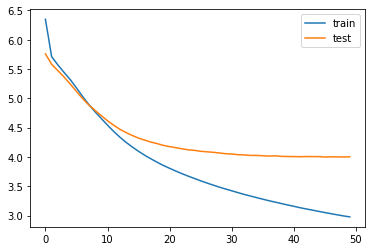

In [42]:
# 학습 손실값과 검증 손실값 비교 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

과적합 문제는 발생한 것 같지 않지만, 모델의 성능이 너무 떨어진다.  
하이퍼 파라미터 및 모델 구조를 변경한 다음 다시 학습을 시켜보도록 한다.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 38, 128)      2432000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 38, 256), (N 394240      embedding_5[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

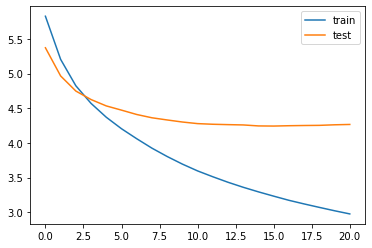

In [44]:
embedding_dim = 128
# 은닉 상태 크기 128에서 256으로 변경
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# LSTM셀 4개에서 3개로 변경, recurrent_dropout 추가
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout=0.4)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)


decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs3])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

optimizer = Adam(learning_rate=0.005)
# 학습률 0.001에서 0.005로 변경
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

어째 성능이 더 안좋아졌지만, 시간 관계 상 계속 진행하도록 한다.

In [45]:
# 정수형으로 변환했던 데이터들을 원문으로 복원
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

학습이 끝났으면 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원하도록한다.

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델을 준비한다.  
그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반봅 구조로 동작하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 변도로 해줘야 한다. 이 때는 인코더와 디코더 모델을 분리해서 설계한다.

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Attention 메커니즘을 사용해서 출력층을 설계한다.

In [53]:
# 단어 시퀀스를 완성하는 함수 정의
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 머릿글의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if i == 0:
            continue
        if i == tar_word_to_index['eostoken']:
            break
        temp += tar_index_to_word[i] + ' '
    return temp

text의 정수 시퀀스에서는 0을 제거하고, headlines의 정수 시쿼스에서는 0과 시작/종료 토큰의 인덱스를 제거한다.

In [55]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : congress monday criticised jammu kashmir cm mehbooba mufti urging centre follow footsteps former pm atal bihari vajpayee dealing kashmir unrest kashmir evolved upa years whether form opening bus roads internal security situations party spokesperson manish tewari said 
실제 요약 : sostoken kashmir under upa govt cong on vajpayee 


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 256 but received input with shape (None, 1, 512)


In [56]:
import requests
from summa.summarizer import summarize

In [57]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [58]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [59]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [60]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [61]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


### 회고

#### KEEP
* 시간에 쫒기지 않고 최대한 이해하려고 노력했다.
#### PROBLEM
* 아직 LSTM에 대해 완전히 이해하지 못했다.
* Attention 메커니즘에 대해 이해하지 못했다.
#### TRY
* LSTM 자료를 찾아보고 더 공부를 해야된다.
* 못 끝낸 프로젝트와 해결하지 못한 에러를 해결한다.